# Data cleaning and EDA

   For identifying scenary themes of the trails, I use labels of photos uploaded by users to alltrails.com. Using Selenium libraries, I extract the link for each photo and pass it to the CNN API (Algorithmia, Places 365) to get five the most probable labels of the photo. I then average values among all photos from the same trail and select the top five labels for each trail.
   

Description of the data:
 1. trail_views1.csv : trails, photo labels, label weights
 2. trails1.csv : other information of the trail, such as length, elevation gain, reviews, tags, etc. The tags are used to validate the clustering approach
 3. trails_geotags.csv : the location of the trail head, also obtained from alltrails.com

In [1]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data with photo labels
data_visual = pd.read_csv('trail_views1.csv')
data_visual = data_visual.drop_duplicates(subset=None, keep='first', inplace=False)
data_visual.head(9)

,title,label,value
0,Breakneck Ridge Trail to South Beacon Mountain,forest/broadleaf,0.055310
1,Breakneck Ridge Trail to South Beacon Mountain,rainforest,0.008948
2,Breakneck Ridge Trail to South Beacon Mountain,forest_path,0.013395
3,Breakneck Ridge Trail to South Beacon Mountain,field/wild,0.006116
4,Breakneck Ridge Trail to South Beacon Mountain,tree_farm,0.015817
10,Bear Mountain Loop Trail,lake/natural,0.016518
11,Bear Mountain Loop Trail,river,0.013038
12,Bear Mountain Loop Trail,pond,0.003657
13,Bear Mountain Loop Trail,marsh,0.006628


In [3]:
# investigate labels counts
data_visual['label'].value_counts()

rainforest                395
valley                    391
forest/broadleaf          351
river                     349
mountain                  339
forest_path               330
mountain_path             288
lake/natural              280
creek                     237
tree_farm                 230
marsh                     216
pond                      206
desert/vegetation         190
swamp                     176
field/wild                146
forest_road               138
tundra                    115
canyon                    102
lagoon                    101
pasture                    97
waterfall                  93
hot_spring                 88
field_road                 71
coast                      64
boardwalk                  62
watering_hole              60
sky                        59
swimming_hole              59
orchard                    56
cliff                      56
                         ... 
cottage                     2
corral                      2
iceberg   

Labels that occur often indeed make sense for New York state parks, while rare labels are unlikely being representative for an outdoor trail in the area. We should investigate a way of removing misleading labels.

Text(0.5, 0, 'Labels')

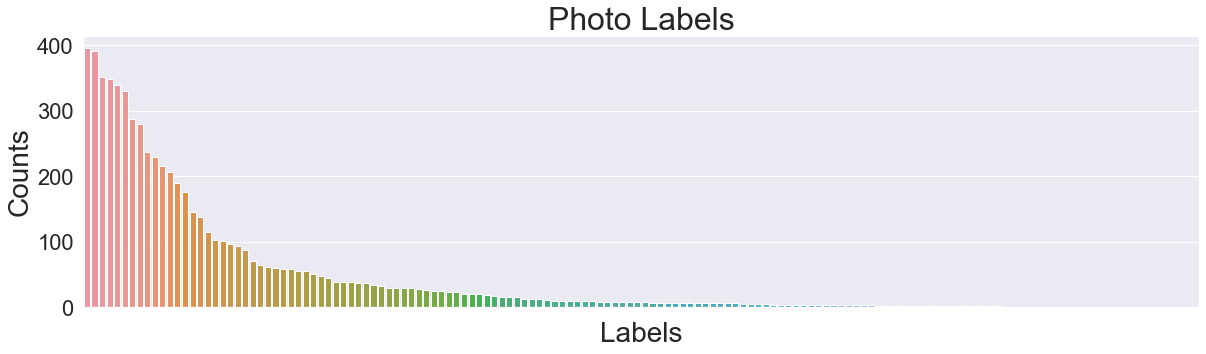

In [4]:
# Plotting the distribution of photo labels

sns.set(rc={'figure.figsize':(20,5)})
sns.set(font_scale = 2)

a = data_visual['label'].value_counts()
labels  = np.array(a.index)
counts = np.array(a.values)

ax = sns.barplot(x = labels,y = counts)
ax.set(xticklabels=[])
ax.set_title('Photo Labels', size = 32)
ax.set_ylabel('Counts', size = 28)
ax.set_xlabel('Labels', size = 28)

I set the cut-off at 12 counts that leaves 95% of total label counts. This reduces the number of unique labels from 148 to 61.

In [5]:
# keep only those labels who appear more than 12 times (keeping roughly 95% of counts)
print(' Data before removing rare labels: \n')
print(data_visual.info())
labels = data_visual['label'].value_counts()
small_labels = labels[labels<12].index
for label in small_labels:
    data_visual = data_visual[data_visual.label != label]
print('\n Data after removing rare labels: \n')
print(data_visual.info())

print('\n Number of unique labels is', len(data_visual['label'].value_counts()))

 Data before removing rare labels: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6525 entries, 0 to 7079
Data columns (total 3 columns):
title    6525 non-null object
label    6525 non-null object
value    6525 non-null float64
dtypes: float64(1), object(2)
memory usage: 203.9+ KB
None

 Data after removing rare labels: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6195 entries, 0 to 7079
Data columns (total 3 columns):
title    6195 non-null object
label    6195 non-null object
value    6195 non-null float64
dtypes: float64(1), object(2)
memory usage: 193.6+ KB
None

 Number of unique labels is 61


After investigating the labels and comparing the CNN training images for 'similar' labels, I have combined some labels into groups and replaced all labels within each group with a single value. This further reduced the number of labels to 43.

In [6]:
#combine some of labels
mountain_labels = ['mountain', 'mountain_snowy','canyon', 'butte','volcano', 'badlands'] # this group will be labeled as 'mountain'
forest_labels = ['forest','bamboo_forest', 'forest/broadleaf', 'rainforest']
field_labels = ['field','pasture', 'field/cultivated','field/wild', 'snowfield','wheat_field', 'hayfield','corn_field']
bridge_labels = ['bridge','aqueduct','viaduct']
forest_road_labels = ['forest_path', 'forest_road']
valley_labels = ['valley', 'tundra', 'desert/vegetation']
young_forest_labels = ['young_forest','tree_farm']

for labels in [mountain_labels, forest_labels, bridge_labels,field_labels,valley_labels,forest_road_labels,young_forest_labels]:
    for label in labels:
        data_visual = data_visual.replace(label, labels[0])
print('Number of unique labels is', len(data_visual['label'].value_counts()))

data_visual.head(10)


Number of unique labels is 43


,title,label,value
0,Breakneck Ridge Trail to South Beacon Mountain,forest,0.055310
1,Breakneck Ridge Trail to South Beacon Mountain,forest,0.008948
2,Breakneck Ridge Trail to South Beacon Mountain,forest_path,0.013395
3,Breakneck Ridge Trail to South Beacon Mountain,field,0.006116
4,Breakneck Ridge Trail to South Beacon Mountain,young_forest,0.015817
10,Bear Mountain Loop Trail,lake/natural,0.016518
11,Bear Mountain Loop Trail,river,0.013038
12,Bear Mountain Loop Trail,pond,0.003657
13,Bear Mountain Loop Trail,marsh,0.006628
14,Bear Mountain Loop Trail,lagoon,0.002839


We now need to pivot the data frame to use the labels as features and trail titles as indexes. Since some of the trails now have multiple occurrences of the same label, thus the proper selection of the aggregation function is sum. 

In [7]:
#pivot the data frame
data_visual_1 = data_visual.pivot_table(index = 'title', columns = 'label', values = 'value', aggfunc={'value': np.sum})
data_visual_1 = data_visual_1.fillna(0)
data_visual_1.head(3)

label,beach,boardwalk,botanical_garden,bridge,canal/natural,cemetery,cliff,coast,creek,dam,...,river,sky,swamp,swimming_hole,trench,valley,vineyard,waterfall,watering_hole,young_forest
title,,,,,,,,,,,,,,,,,,,,,
3-Lakes Charcoal Burners and Fahnestock Loop via Appalachian Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.005915,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Acra Point via Black Dome Range Trail to Escarpment Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.064591,0.0,0.0,0.0,0.0
Acra Point via Black Dome Range and Escarpment Trails,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.108783,0.0,0.0,0.0,0.0


In [8]:
#normalized columns with float values

for col in data_visual_1.columns:
 
    x = data_visual_1[col]
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    data_visual_1[col] = x
    
data_visual_1.head()

label,beach,boardwalk,botanical_garden,bridge,canal/natural,cemetery,cliff,coast,creek,dam,...,river,sky,swamp,swimming_hole,trench,valley,vineyard,waterfall,watering_hole,young_forest
title,,,,,,,,,,,,,,,,,,,,,
3-Lakes Charcoal Burners and Fahnestock Loop via Appalachian Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.06299,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000
Acra Point via Black Dome Range Trail to Escarpment Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.196871,0.0,0.0,0.0,0.00000
Acra Point via Black Dome Range and Escarpment Trails,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.331568,0.0,0.0,0.0,0.00000
Africa Loop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.617341,0.0,0.0,0.0,0.06516
Alander Mountain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.543995,0.0,0.0,0.0,0.00000


# Model (clustering)

In [9]:
# import libraries
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [10]:
# only visual attributes are used for clustering
X = data_visual_1.copy()

I want to have trail groups centered around certain topics. For this, I plan to use K-means, which would give spherically symmetrical clusters. K-means clustering has an uncertainty related to random initialization of clusters. Thus, I want to use hierarchical clustering (with Ward linkage) to identify the initial cluster centroids for K-means.  But first, I want to evaluate the most optimal number of clusters using distortion and silhouette score (averaged over repeated random initializations)

### Identifying cluster number

In [11]:
n_cl_max = 50 # maximum number of clusters
n_cls = range(2,n_cl_max)
silhouette =np.zeros(n_cl_max-2)
distortions =np.zeros(n_cl_max-2)

runs = 50 #number of random initializations

for j in range(runs):
    for n_cl in n_cls:
        
        # fit model 
        kmeans = KMeans(n_clusters=n_cl, n_init =1 ).fit(X)
        trails_clusters=kmeans.predict(X)
        
        # calculate silhouette score
        silhouette_avg = silhouette_score(X, trails_clusters)
        silhouette[n_cl-2] += silhouette_avg/(runs)
        
        # calculate distortions
        distortion = kmeans.inertia_
        distortions[n_cl-2] += distortion/(runs)

        

Text(0, 0.5, 'Distortion')

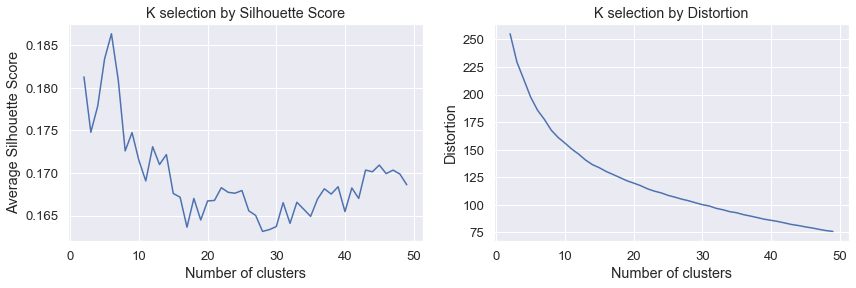

In [12]:
# visualizing silhouette score and distortion

sns.set(rc={'figure.figsize':(14,4)})
sns.set(font_scale = 1.2)

fig, axs = plt.subplots(ncols=2)

sns.lineplot(x = n_cls, y = silhouette, ax=axs[0])
axs[0].set_title('K selection by Silhouette Score')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Average Silhouette Score')


sns.lineplot(x = n_cls, y = distortions, ax=axs[1])
axs[1].set_title('K selection by Distortion')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Distortion')

The distortion plot does not have any pronounced 'elbow' and thus cannot be used for selecting the number of clusters. The smooth trend of distortion line also implies that there is no strong cluster structure in the data, which is confirmed by the overall low silhouette score (<0.25). This is expectable because NY state does not have drastically different landscapes throughout its territory. 
From the silhouette score plot it can be seen that the optimal number of clusters is between 4 and 7. I would expect costal trails (Long Island) to form a separate cluster. Guided by this idea, I increase the number of clusters and check if/when one of the cluster centroids reflects the coastal theme (selection is not shown). The model with N_clusters = 6 gives the costal cluster. Increasing the number of clusters to 7 does not produce an obvious new visual theme and I select 6 clusters for the model.


### Clustering

In [13]:
n_cl=6 # number of clusters

# determine centroids based on the results of agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters = n_cl, linkage ='ward').fit(X) 
centers = []
for j in range(n_cl):
    row = X[agg_clustering.labels_==j].mean().values
    centers.append(row)
centers_k=np.array(centers)
centers_k.shape

# performing K-means clusterization
kmeans = KMeans(n_clusters=n_cl, init= centers_k).fit(X)
trails_clusters=kmeans.predict(X)

### Analysis of cluster centroids

In [14]:
# select the most prominate features in coordinates of all cluster centroids among all clusters

centers =kmeans.cluster_centers_
table = []
for j in range(0,n_cl):
    row = []
    for l in range (0,len(X.columns)):
        row.append(centers[j][l])
    table.append(row)


w = pd.DataFrame(table, columns = X.columns)
w.head(40)

label,beach,boardwalk,botanical_garden,bridge,canal/natural,cemetery,cliff,coast,creek,dam,...,river,sky,swamp,swimming_hole,trench,valley,vineyard,waterfall,watering_hole,young_forest
0,8.513493e-03,2.613710e-05,-8.673617e-19,2.638566e-03,1.194592e-02,7.372575e-18,7.404953e-04,9.959622e-03,1.205495e-02,8.557465e-03,...,0.207290,9.856773e-03,8.331205e-02,1.355032e-02,5.204170e-18,0.017117,-7.372575e-18,2.556042e-04,1.038287e-02,1.982729e-03
1,-5.204170e-18,2.228425e-03,1.146826e-02,1.135666e-03,-7.806256e-18,2.088859e-03,-3.469447e-18,-4.510281e-17,2.182729e-02,1.040834e-17,...,0.002655,5.729645e-03,3.282148e-02,2.371450e-05,4.869602e-03,0.016086,5.918732e-03,3.424155e-03,6.005320e-05,1.347682e-02
2,3.355910e-03,7.797326e-03,7.897960e-03,7.756320e-03,6.009588e-03,4.008876e-03,1.998221e-03,5.655831e-03,2.263187e-02,7.880288e-03,...,0.017038,6.292956e-03,1.141901e-02,2.555990e-03,4.868810e-03,0.036475,4.418097e-03,3.939162e-03,1.817752e-03,2.207827e-02
3,-2.602085e-18,-3.469447e-18,-8.673617e-19,4.685651e-04,7.806256e-18,2.602085e-18,1.434734e-03,-2.949030e-17,4.201058e-01,3.123631e-02,...,0.064261,1.387779e-17,9.666320e-03,1.957910e-02,2.065118e-03,0.000580,2.602085e-18,3.085804e-01,3.408155e-03,5.677973e-04
4,2.558671e-01,4.841211e-03,-8.673617e-19,8.673617e-19,0.000000e+00,-8.673617e-19,1.621320e-01,6.219947e-01,-1.387779e-17,3.148139e-03,...,0.000516,8.136160e-02,0.000000e+00,-8.673617e-19,4.336809e-19,0.005977,-1.301043e-18,-1.040834e-17,8.673617e-19,3.469447e-18
5,4.336809e-18,-1.387779e-17,1.127570e-17,5.147327e-04,-3.469447e-18,8.239937e-18,7.470059e-03,-4.510281e-17,1.559177e-03,5.019744e-03,...,0.006248,1.152079e-02,-3.816392e-17,2.081668e-17,2.656886e-04,0.372049,8.370401e-04,5.551115e-17,-7.372575e-18,1.173219e-02


In [15]:
# select only the most prominet features for visualization of cluster centers

unimportant_col =[]
for col in w.columns:
    if w[col].max() < 0.05:
        unimportant_col.append(col)

Y = w.drop(columns = unimportant_col) #centroids

In [16]:
# look at the themes of the clusters by listing the five largest features for each cluster

theme=[]
for j in range(w.shape[0]):
    row = w.iloc[j]
#     print(row.sort_values(ascending = False))
    most_photographed = row.sort_values(ascending = False)[:5]
    theme.append(list(most_photographed.index))
    print(j, list(most_photographed.index))
    
w['theme'] = theme

0 ['river', 'lake/natural', 'lagoon', 'swamp', 'pond']
1 ['forest', 'forest_path', 'swamp', 'creek', 'valley']
2 ['forest_path', 'valley', 'field', 'forest', 'creek']
3 ['creek', 'waterfall', 'river', 'mountain', 'hot_spring']
4 ['coast', 'ocean', 'beach', 'cliff', 'lagoon']
5 ['valley', 'mountain_path', 'mountain', 'forest', 'desert_road']


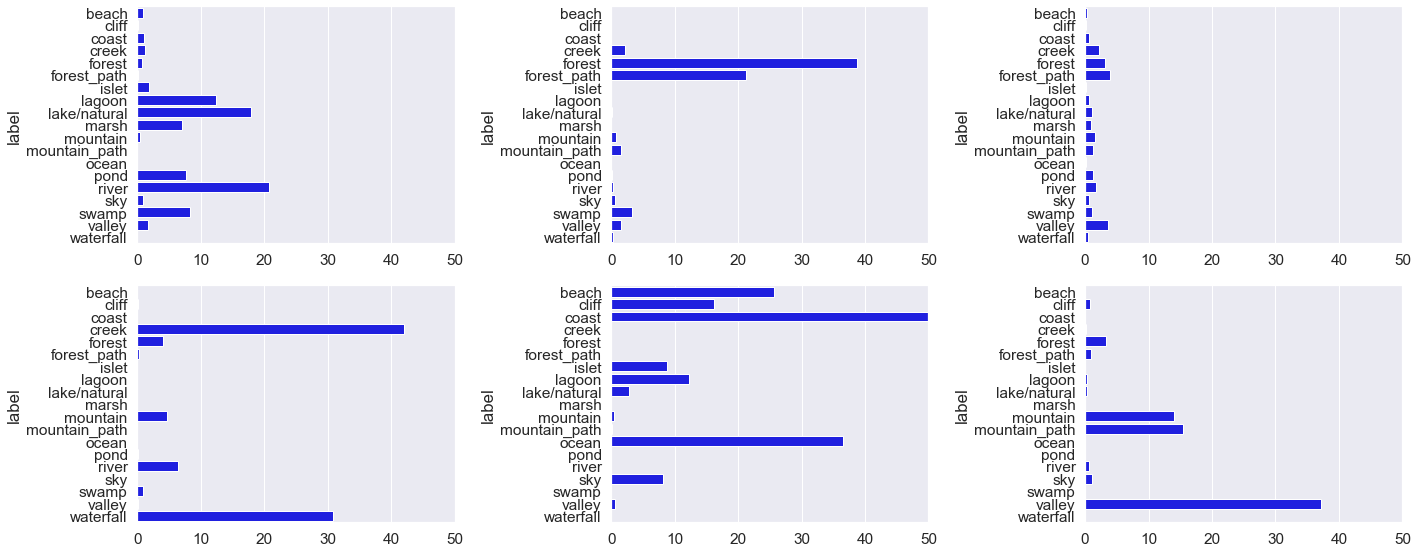

In [17]:
# Visualizing centroids

sns.set(rc={'figure.figsize':(20,8)})
sns.set(font_scale = 1.4)

figure, axs = plt.subplots(ncols = 3, nrows= 2)
for j in range(6):
    row = Y.loc[j]
    r = int(j/3)
    c = j%3
    axs[r,c] = sns.barplot(x=row.values*100, y=row.index,color="blue", ax=axs[r, c])
    axs[r,c].set_xlim(0,50)
plt.tight_layout()


# Model analysis and validation

Text(0.5, 0, '')

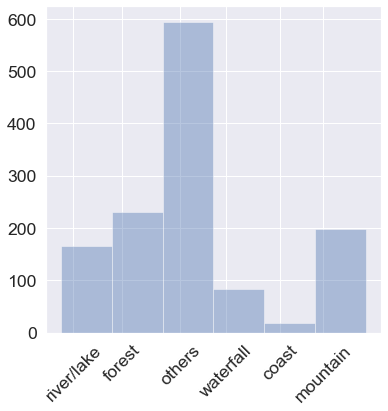

In [18]:
# Visualizing number of trails in clusters

clustered_data = X.copy()
clustered_data['cluster'] = trails_clusters


sns.set(rc={'figure.figsize':(6,6)})
sns.set(font_scale = 1.6)


ax = sns.distplot(clustered_data['cluster'], kde = False, bins =6)
ax.set(xticks=[0.20, 1.0, 1.95, 2.7, 3.6, 4.3], )
ax.set_xticklabels(['river/lake','forest', 'others','waterfall', 'coast','mountain' ],rotation = 45)
ax.set_xlabel('')


As expected, the coast-themed cluster has the smallest number of trails in it. The largest cluster is the one with no specific theme ('a little bit of everything'), with is expected from common sense. Large portion of trails have forest, fields and water.

Below I use 2 principle components for visualization of clustered data

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Y = pd.DataFrame(pca.fit_transform(X))
X['pca1'] = Y[0].values
X['pca2'] = Y[1].values
X['cluster'] = clustered_data['cluster']

print(pca.explained_variance_ratio_) 

[0.16531914 0.12933651]


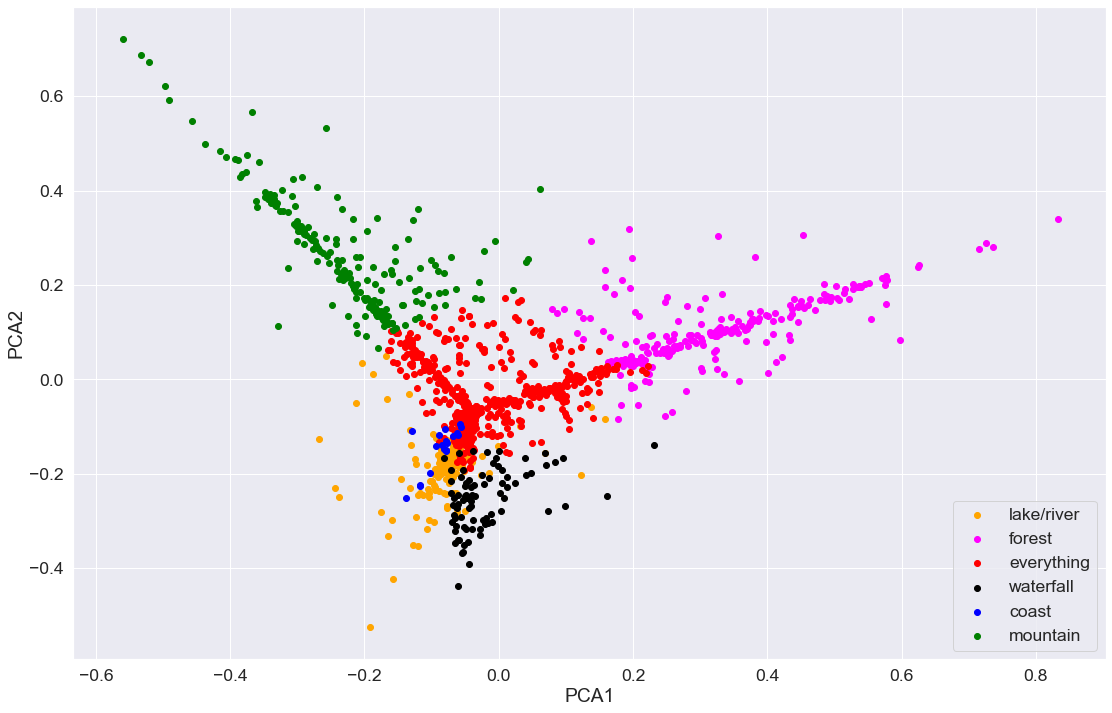

In [20]:
scatter_x = X['pca1'].values
scatter_y =  X['pca2'].values
group = X['cluster'].values
cdict = {0: 'orange',1: 'magenta', 3: 'black', 4: 'blue', 5:'green', 6: 'black' , 2: 'red'}
cluster_dict = {0: 'lake/river',1: 'forest', 2: 'everything', 3: 'waterfall', 4: 'coast', 5:'mountain' }

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 12)
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = cluster_dict[g])
    
ax.legend()
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.legend(loc =4)
plt.show()

From visualization one can see three major areas: mountain, forest and water. The largest cluster is on the intersection of these directions.

### Validation

Further I check if defining a trail visual theme through analysis of users' photos and clustering is reasonable. For this I compare the tags from the website to the most similar theme of the cluster. Keep in mind that it is not clear how the tags are formed and not all themes have a corresponding tag (e.g. mountain theme).

In [21]:
# create lists of trails in each cluster

forest_cluster = list(clustered_data[clustered_data['cluster'] == 1].index)
mountain_cluster = list(clustered_data[clustered_data['cluster'] == 5].index)
coast_cluster = list(clustered_data[clustered_data['cluster'] == 4].index)
river_lake_cluster = list(clustered_data[clustered_data['cluster'] == 0].index)
waterfall_cluster = list(clustered_data[clustered_data['cluster'] == 3].index)
others_cluster = list(clustered_data[clustered_data['cluster'] == 2].index)
cluster_list = list(clustered_data.index)

In [22]:
# loading another set of scraped data (includes tags provided by alltrail.com)

data = pd.read_csv('trails1.csv')
data = data.set_index('title')
data = data.loc[~data.index.duplicated(keep='first')]
data.head()

,avg_rating,backpacking,beach,biking,cave,city_walk,difficulty,dog,driving,elevation,...,horseback,lake,length,park_name,paved,review_counts,river,rock_climbing,rout_type,waterfall
title,,,,,,,,,,,,,,,,,,,,,
Breakneck Ridge Trail to South Beacon Mountain,4.7,1,0,0,0,0,HARD,2,0,"3,123 feet",...,0,0,8.6 miles,Hudson Highlands State Park,1,1039,1,1,Out & Back,0
Bear Mountain Loop Trail,4.4,0,0,0,0,0,MODERATE,0,0,"1,059 feet",...,0,1,3.6 miles,Bear Mountain State Park,0,742,1,0,Loop,0
Cascade Mountain and Porter Mountain via Cascade Mountain Trail,4.6,0,0,0,0,0,MODERATE,0,0,"2,293 feet",...,0,0,5.6 miles,none,0,829,1,1,Out & Back,0
Overlook Mountain Trail,4.4,0,0,0,0,0,MODERATE,0,0,"1,397 feet",...,0,0,4.6 miles,Overlook Mountain Wild Forest,0,685,0,0,Out & Back,0
Mount Marcy via Van Hoevenberg Trail,4.7,1,0,0,0,0,HARD,0,0,"3,513 feet",...,0,1,14.1 miles,High Peaks Wilderness,0,452,1,1,Out & Back,1


In [23]:
# get list of trails with tags provided by the website for the trails that are also present in the trails_view dataset
within = []
for trail in list(data.index):
    within.append(trail in cluster_list)
data1 = data[within]


forest_trails = list(data1[data1['forest'] == 1].index)
trails_list = list(data1.index)
beach_trails = list(data1[data1['beach'] == 1].index)
river_trails = list(data1[data1['river'] == 1].index)
lake_trails = list(data1[data1['lake'] == 1].index)
waterfall_trails = list(data1[data1['waterfall'] == 1].index)

In [24]:
# look at the intersection of all clusters

def trail_intersection(lst1, lst2): 
    return set(lst1).intersection(lst2) 


print('river_lake and lake (tag) intersection: ', len(trail_intersection(river_lake_cluster, lake_trails))/len(river_lake_cluster))
print('river_lake and river (tag) intersection: ', len(trail_intersection(river_lake_cluster, river_trails))/len(river_lake_cluster))
print('forest and forest (tag) intersection: ', len(trail_intersection(forest_cluster, forest_trails))/len(forest_cluster))
print('coast and beach (tag) intersection: ', len(trail_intersection(coast_cluster, beach_trails))/len(coast_cluster))
print('waterfall and waterfall (tag) intersection: ', len(trail_intersection(waterfall_cluster, waterfall_trails))/len(waterfall_cluster))


river_lake and lake (tag) intersection:  0.6181818181818182
river_lake and river (tag) intersection:  0.23030303030303031
forest and forest (tag) intersection:  0.808695652173913
coast and beach (tag) intersection:  0.7894736842105263
waterfall and waterfall (tag) intersection:  0.7951807228915663


The intersection between lists of trails from a cluster and a corresponding tag is pretty high, which confirms that our approach of identifying scenery theme is reasonable.

# Preparing data for recommendation application

For recommending a trail for a user, the application will rank the trails from the same cluster within the indicated geographical location using cosine similarity. I also include the elevation and length of the trail into features for measuring similarity.

In [25]:
# getting trail length and elevation gain
data_reduced = data[['elevation','length']]

# extract length in miles
def miles(x):
    return float(x.split()[0])
data_reduced.loc[:,'length'] = data_reduced['length'].apply(miles).values


# extract elevation in ft
def feet(x):   
    return float(''.join(x.split()[0].split(',')))

data_reduced.loc[:,'elevation'] = data_reduced['elevation'].apply(feet).values

data_reduced.head()

,elevation,length
title,,
Breakneck Ridge Trail to South Beacon Mountain,3123.0,8.6
Bear Mountain Loop Trail,1059.0,3.6
Cascade Mountain and Porter Mountain via Cascade Mountain Trail,2293.0,5.6
Overlook Mountain Trail,1397.0,4.6
Mount Marcy via Van Hoevenberg Trail,3513.0,14.1


In [26]:
# there is an outlier that need to be removed for normalizing the lenth and elevation
data_reduced.max()

elevation    68077.0
length         424.0
dtype: float64

In [27]:
# remove the outliear
data_reduced = data_reduced[data_reduced['elevation'] < data_reduced['elevation'].max()]
data_reduced = data_reduced[data_reduced['length'] < data_reduced['length'].max()]

In [28]:
for col in data_reduced.columns:
    x = data_reduced[col]
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    data_reduced[col] = x

In [29]:
# merge the visual features with elevation and length
new_df = pd.merge(X, data_reduced, how='inner', on='title', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
new_df.head()

,beach,boardwalk,botanical_garden,bridge,canal/natural,cemetery,cliff,coast,creek,dam,...,valley,vineyard,waterfall,watering_hole,young_forest,pca1,pca2,cluster,elevation,length
title,,,,,,,,,,,,,,,,,,,,,
3-Lakes Charcoal Burners and Fahnestock Loop via Appalachian Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.188079,0.042830,1,0.026274,0.054280
Acra Point via Black Dome Range Trail to Escarpment Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.196871,0.0,0.0,0.0,0.00000,-0.187893,0.146039,5,0.050335,0.051148
Acra Point via Black Dome Range and Escarpment Trails,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.331568,0.0,0.0,0.0,0.00000,-0.211923,0.184544,5,0.046152,0.036534
Africa Loop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.617341,0.0,0.0,0.0,0.06516,-0.326192,0.356105,5,0.122810,0.117954
Alander Mountain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.543995,0.0,0.0,0.0,0.00000,-0.329790,0.373312,5,0.082612,0.052192


In [30]:
# load trail geolocations
trail_tag = pd.read_csv('trails_geotags.csv')
trail_tag=trail_tag.set_index(['title'])
trail_tag.head()

,latitude,longitude
title,,
Breakneck Ridge Trail to South Beacon Mountain,41.44563,-73.97908
Bear Mountain Loop Trail,41.31045,-73.99066
Cascade Mountain and Porter Mountain via Cascade Mountain Trail,44.21897,-73.88768
Overlook Mountain Trail,42.07109,-74.12271
Mount Marcy via Van Hoevenberg Trail,44.18296,-73.96380


In [31]:
# merge new_df and geodata
trails = pd.merge(new_df, trail_tag, how='inner', on='title', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
trails = trails.rename(columns={"trail_cluster": "cluster"})
trails = trails.loc[~trails.index.duplicated(keep='first')]

# record the data
export_csv = trails.to_csv('trail_geotags_clusters_.csv', index = 'title', header=True)
trails.head()

,beach,boardwalk,botanical_garden,bridge,canal/natural,cemetery,cliff,coast,creek,dam,...,waterfall,watering_hole,young_forest,pca1,pca2,cluster,elevation,length,latitude,longitude
title,,,,,,,,,,,,,,,,,,,,,
3-Lakes Charcoal Burners and Fahnestock Loop via Appalachian Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.188079,0.042830,1,0.026274,0.054280,41.453260,-73.836460
Acra Point via Black Dome Range Trail to Escarpment Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,-0.187893,0.146039,5,0.050335,0.051148,42.289020,-74.115790
Acra Point via Black Dome Range and Escarpment Trails,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,-0.211923,0.184544,5,0.046152,0.036534,42.288930,-74.115040
Africa Loop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.06516,-0.326192,0.356105,5,0.122810,0.117954,41.264336,-74.154389
Alander Mountain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,-0.329790,0.373312,5,0.082612,0.052192,42.065220,-73.515330


The above dataframe is used in the Flask application for recommending trails.